# Collecting data from an environment

In [31]:
from cc.collect import (
    collect,
    collect_reference_source,
    collect_sample,
    concat_iterators
)
from cc import save, load 
from cc.env import make_env
from cc.utils import generate_ts
from cc.env.wrappers import AddReferenceObservationWrapper
from cc.env.wrappers.add_source import default_reward_fn
import matplotlib.pyplot as plt 

In [5]:
time_limit=5.0 # s
control_timestep=0.01 # s 

env = make_env(
    "two_segments_v1", 
    random=1, # the initial condition might be randomized; fixes the seed 
    control_timestep=control_timestep, # the control rate, here 100 Hz 
    time_limit=time_limit, # the upper time limit; after 5 seconds the environment is done
    delay=0 # whether or not the action is delayed before the environment sees it 
    )

In [8]:
ts = generate_ts(time_limit, control_timestep)

##### Therefore the length of an episode trajectory will be

In [9]:
N = len(ts)+1 # +1 for the initial state (no action performed yet)
N

501

#### And we apply inputs at those timesteps

In [10]:
ts[:20]

DeviceArray([0.        , 0.01      , 0.02      , 0.03      , 0.04      ,
             0.05      , 0.06      , 0.07      , 0.08      , 0.09      ,
             0.09999999, 0.11      , 0.12      , 0.13      , 0.14      ,
             0.14999999, 0.16      , 0.17      , 0.17999999, 0.19      ],            dtype=float32)

#### The input to the system and observation from the system is of the form

In [11]:
env.action_spec()

BoundedArray(shape=(1,), dtype=dtype('float32'), name=None, minimum=[-1.e+10], maximum=[1.e+10])

In [12]:
env.observation_spec()

OrderedDict([('xpos_of_segment_end',
              Array(shape=(1,), dtype=dtype('float32'), name='xpos_of_segment_end'))])

In [13]:
env.step([0.1])

TimeStep(step_type=<StepType.MID: 1>, reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=OrderedDict([('xpos_of_segment_end', array([4.9619352e-06], dtype=float32))]))

In [14]:
env.reset()

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=OrderedDict([('xpos_of_segment_end', array([2.5717583e-16], dtype=float32))]))

##### Let's collect some data from the environment

In [16]:
train_sample = collect_sample(
    env, 
    seeds_gp=[0,1,2], # this uses a gaussian process to draw some fixed action/input trajectories 
                        # that we then can apply to the system and record the output
    seeds_cos=[2,4] # this uses a cosine-wave with a frequency of 2 and 4; really this shouldn't 
                        # be called seed 
    )

COMPILING object <class 'cc.controller.controller.FeedforwardController'>


In [25]:
type(train_sample)

cc.buffer.sampler.ReplaySample

In [18]:
train_sample.bs

5

In [20]:
train_sample.action.shape

(5, 500, 1)

In [21]:
train_sample.obs["xpos_of_segment_end"].shape

(5, 501, 1)

Text(0, 0.5, 'Motor input')

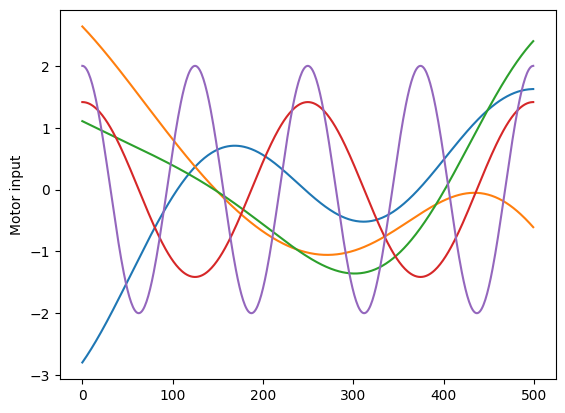

In [24]:
for idx in range(train_sample.bs):
    plt.plot(train_sample.action[idx])
plt.ylabel("Motor input")

Text(0, 0.5, 'X-Position')

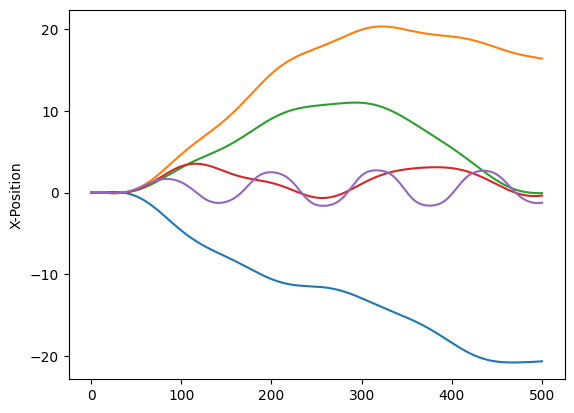

In [23]:
for idx in range(train_sample.bs):
    plt.plot(train_sample.obs["xpos_of_segment_end"][idx])
plt.ylabel("X-Position")

In [29]:
train_sample.rew[0,:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

Notice how there is no reward, how could there be? 

We have to add 
- first, create some reference output that we want to track
- second, add the reference to the environment and specify a reward-function

Let's now create an arbitrary smooth input-trajectory, record the observation of that input as reference and store it 

In [30]:
source = collect_reference_source(env, 
    seeds = [0,17], # this should really be called seeds_gp 
    constant_after=False, # if we enable this flag the reference will become constant after 3 seconds 
    constant_after_T=3.0 # unused 
)

In [32]:
env_w_rew = AddReferenceObservationWrapper(env, 
    source=source,
    reward_fn=default_reward_fn 
)

Now, the observation is the reference and the actual observation

In [34]:
env_w_rew.observation_spec()

OrderedDict([('obs',
              OrderedDict([('xpos_of_segment_end',
                            Array(shape=(1,), dtype=dtype('float32'), name='xpos_of_segment_end'))])),
             ('ref',
              OrderedDict([('xpos_of_segment_end',
                            Array(shape=(1,), dtype=dtype('float32'), name='xpos_of_segment_end'))]))])

And the environment now has some reward

In [41]:
env_w_rew.step([0.1]).reward

-9.101565296987246e-07

In [42]:
env_w_rew.step([0.1]).reward

-5.430573310150066e-06

Remember, how our source contains *2* trajectories. So, which one are we currently "seeing" in this environment in the observation

In [43]:
source._i_actor

0

In [45]:
env_w_rew.reset()
env_w_rew.step([0.1]).observation["ref"]

OrderedDict([('xpos_of_segment_end',
              DeviceArray([-6.1108185e-05], dtype=float32))])

In [46]:
# let's change the reference to the second one 
source.change_reference_of_actor(1)
source._i_actor

1

In [47]:
# now it is different
env_w_rew.reset()
env_w_rew.step([0.1]).observation["ref"]

OrderedDict([('xpos_of_segment_end',
              DeviceArray([1.5516744e-05], dtype=float32))])

### Now we have all the components to 
- get Training/Testing-data for the training of a *model* using `collect_sample`
- get suible Reference Trajectories using `collect_reference_source` and add this reference to the environment

##### Finally, you can also save/load `source` and `train_sample` using the functions `save` and `load`

In [ ]:
save(train_sample, "train_sample.pkl")
load("train_sample.pkl")